### Analysis of results
The following ipython notebook demonstrates how results from multiple sweeps can be analysed and summarised. 

In [1]:
import plotnine as ggp
from scipy.stats import wilcoxon, ttest_rel
from utils import *

dbs = {
    'aumc': 'AUMCdb',
    'hirid': 'HiRID',
    'eicu': 'eICU',
    'miiv': 'MIMIC',
    'pooled (n-1)': 'pooled (n-1)',
    'all': 'all'
}

algos = ['ERM', 'CORAL', 'VREx', 'Fishr', 'MLDG', 'GroupDRO']

/opt/homebrew/Caskroom/miniconda/base/envs/clinicaldg-new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


First, we need to define which task and model architecture should be summarised. These experiments can then be loaded and aggregated using the helper functions defined in utils.  

In [2]:
task = 'icu-mortality'
model = 'gru'
path = Path(f'/Users/patrick/icuDG-outputs/{task}_{model}')

# Load and aggregate the results
grps = ['algorithm', 'val_env', 'test_env']
res = load_model_performance(path)          # Load all results
agg_res = aggregate_results(res, grps)      # Aggregate across trials
bst_res = pick_best_result(agg_res, grps)   # Choose the best set
summ = summ_mean_ste(bst_res, "auroc")      # Summarise best set

# NOTE: this run summarised 5 trials of 10 hyperparameter combinations
# - 50x ERMMerged
# - 200x ERMID, ERM, CORAL, VREx, Fishr, MLDG, GroupDRO
# = 1450 models 

1450it [00:00, 9122.25it/s]


Next, we tabulate/plot the results of the different ERM runs (ERMMerged, ERMID, ERM).

In [3]:
# tabulate ERM performance
tbl = summ.melt(id_vars=grps+['hparams_seed'])

tbl['train_env'] = tbl['test_env']
tbl['test_env'] = tbl['variable'].str.extract('^([^_]*)(?=_)')

tbl = tbl[tbl['algorithm'].str.contains("ERM")]
tbl = tbl[tbl['variable'].str.contains("auroc")]
tbl = tbl[(tbl['algorithm'] != 'ERM') | (tbl.train_env == tbl.test_env)]

tbl.loc[tbl['algorithm'] == 'ERM', 'train_env'] = 'pooled (n-1)'

erm = tbl.pivot_table(
    values='value', 
    index='train_env', 
    columns = 'test_env', 
    aggfunc = lambda x: x
)
erm = erm.loc[list(dbs.keys()), list(dbs.keys())[:4]]
erm

test_env,aumc,hirid,eicu,miiv
train_env,,,,
aumc,0.843±0.005,0.740±0.012,0.771±0.003,0.771±0.005
hirid,0.735±0.007,0.842±0.009,0.735±0.003,0.757±0.004
eicu,0.811±0.006,0.777±0.007,0.842±0.001,0.820±0.004
miiv,0.816±0.005,0.800±0.006,0.825±0.002,0.861±0.002
pooled (n-1),0.819±0.005,0.791±0.006,0.827±0.004,0.833±0.002
all,0.841±0.003,0.853±0.006,0.847±0.002,0.862±0.003


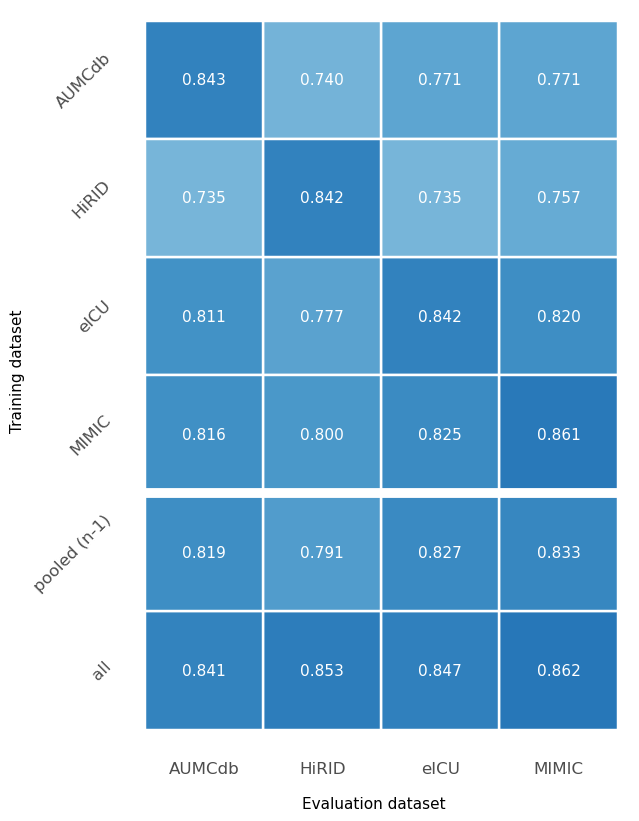

<ggplot: (399106521)>

In [4]:
# Plot ERM performance
plt = tbl.copy()
plt['value_str'] = plt['value'].str.slice(stop=5)
plt['value'] = plt['value_str'].astype(float)

g = (ggp.ggplot(plt, ggp.aes('test_env', 'train_env'))
     + ggp.geom_tile(ggp.aes(fill='value'), colour='white', size=1)
     + ggp.geom_text(ggp.aes(label='value_str'), colour='white') 
     + ggp.geom_hline(yintercept=2.5, size=4, colour='white')
     + ggp.coord_equal() 
     + ggp.scale_x_discrete(
        limits=list(dbs.keys())[:4],
        labels=list(dbs.values())[:4]
       )
     + ggp.scale_y_discrete(
        limits=list(dbs.keys())[::-1],
        labels=list(dbs.values())[::-1]
       )
     + ggp.scale_fill_cmap(cmap_name='Blues', limits=[0.5, 1.0], expand=(0, 0))
     #+ ggp.guides(fill=ggp.guide_colourbar(barheight=50))
     + ggp.guides(fill=None)
     + ggp.labs(
        x='\nEvaluation dataset',
        y='Training dataset',
        fill=''
       )
     + ggp.theme_minimal()
     + ggp.theme(
        axis_text_x=ggp.element_text(size=12),
        axis_text_y=ggp.element_text(size=12, angle=45), 
        legend_text=ggp.element_text(size=12),
        panel_grid=ggp.element_blank()
       )
    )
g

We then compare the performance of the pooled (n-1) ERM to that of all included DG algorithms.

In [5]:
# tabulate DG performance
tbl = summ.melt(id_vars=grps+['hparams_seed'])

tbl['evaluated_in'] = tbl['variable'].str.extract('^([^_]*)(?=_)')

tbl = tbl[~tbl['algorithm'].isin(["ERMMerged", "ERMID"])]
tbl = tbl[tbl['test_env'] == tbl['evaluated_in']]

dg = tbl.pivot_table(
    values='value', 
    index='algorithm', 
    columns = 'evaluated_in', 
    aggfunc = lambda x: x
)
dg = dg.loc[algos, list(dbs.keys())[:4]]
dg

evaluated_in,aumc,hirid,eicu,miiv
algorithm,,,,
ERM,0.819±0.005,0.791±0.006,0.827±0.004,0.833±0.002
CORAL,0.816±0.006,0.785±0.011,0.828±0.002,0.835±0.004
VREx,0.822±0.005,0.791±0.007,0.818±0.002,0.824±0.003
Fishr,0.803±0.009,0.679±0.006,0.803±0.003,0.690±0.029
MLDG,0.825±0.003,0.801±0.003,0.820±0.003,0.837±0.001
GroupDRO,0.823±0.007,0.801±0.008,0.826±0.002,0.848±0.002


Finally, we use a Wilcoxon rank-sum test to test for differences between 

In [6]:
# test for differences to ERM
# NOTE: because of the small size of resamples, the smallest possible p-value is 0.0625

exp = ['algorithm', 'test_env', 'hparams_seed']
setting = tbl[exp]
runs = setting.merge(res, on=exp)

drop_cols = [c for c in runs.columns if "es_" in c or "nll" in c]
perf = runs.drop(columns=drop_cols+['folder']).melt(id_vars=grps+['hparams_seed', 'trial'])
perf = perf[perf['variable'].str.extract("^([a-z]+)").values.squeeze() == perf['test_env'].values]

paired = perf[perf.algorithm == "ERM"].\
    drop(columns=['algorithm', 'val_env', 'hparams_seed', 'variable']).\
    merge(
        perf[perf.algorithm != "ERM"].drop(columns=['val_env', 'hparams_seed', 'variable']), 
        on=['test_env', 'trial'],
        suffixes=['_erm', '_dg']
    )

def compare_to_erm(df, test=ttest_rel):
    # Perform a one-sided test for hypothesis DG != ERM
    res = test(df.value_dg.to_numpy(), df.value_erm.to_numpy(), alternative="two-sided")
    return res.pvalue

paired.groupby(['algorithm', 'test_env']).apply(compare_to_erm, test=wilcoxon).loc[algos, :]


/var/folders/f4/k7z3btlx0tdgf95znm5mkj_w0000gn/T/ipykernel_29848/1401068676.py:25: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`


algorithm  test_env
CORAL      aumc        1.0000
           eicu        1.0000
           hirid       1.0000
           miiv        0.8125
VREx       aumc        0.6250
           eicu        0.3125
           hirid       1.0000
           miiv        0.0625
Fishr      aumc        0.3125
           eicu        0.0625
           hirid       0.0625
           miiv        0.0625
MLDG       aumc        0.1875
           eicu        0.3125
           hirid       0.4375
           miiv        0.1250
GroupDRO   aumc        0.8125
           eicu        1.0000
           hirid       0.4375
           miiv        0.0625
dtype: float64